In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from utils import Utils, k_fold_cross
from smote import Smote
from logistic_regression import LogisticRegression
from naive_bayes import NaiveBayes
from pca import PCA
from KNN import KNN

In [2]:
## Reading the data
df = pd.read_csv('students_adaptability_level_online_education.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Gender               1205 non-null   object
 1   Age                  1205 non-null   object
 2   Education Level      1205 non-null   object
 3   Institution Type     1205 non-null   object
 4   IT Student           1205 non-null   object
 5   Location             1205 non-null   object
 6   Load-shedding        1205 non-null   object
 7   Financial Condition  1205 non-null   object
 8   Internet Type        1205 non-null   object
 9   Network Type         1205 non-null   object
 10  Class Duration       1205 non-null   object
 11  Self Lms             1205 non-null   object
 12  Device               1205 non-null   object
 13  Adaptivity Level     1205 non-null   object
dtypes: object(14)
memory usage: 131.9+ KB


In [3]:
# Checking the features
df.describe().T

,count,unique,top,freq
Gender,1205,2,Boy,663
Age,1205,6,21-25,374
Education Level,1205,3,School,530
Institution Type,1205,2,Non Government,823
IT Student,1205,2,No,901
Location,1205,2,Yes,935
Load-shedding,1205,2,Low,1004
Financial Condition,1205,3,Mid,878
Internet Type,1205,2,Mobile Data,695
Network Type,1205,3,4G,775


## Data Analysis

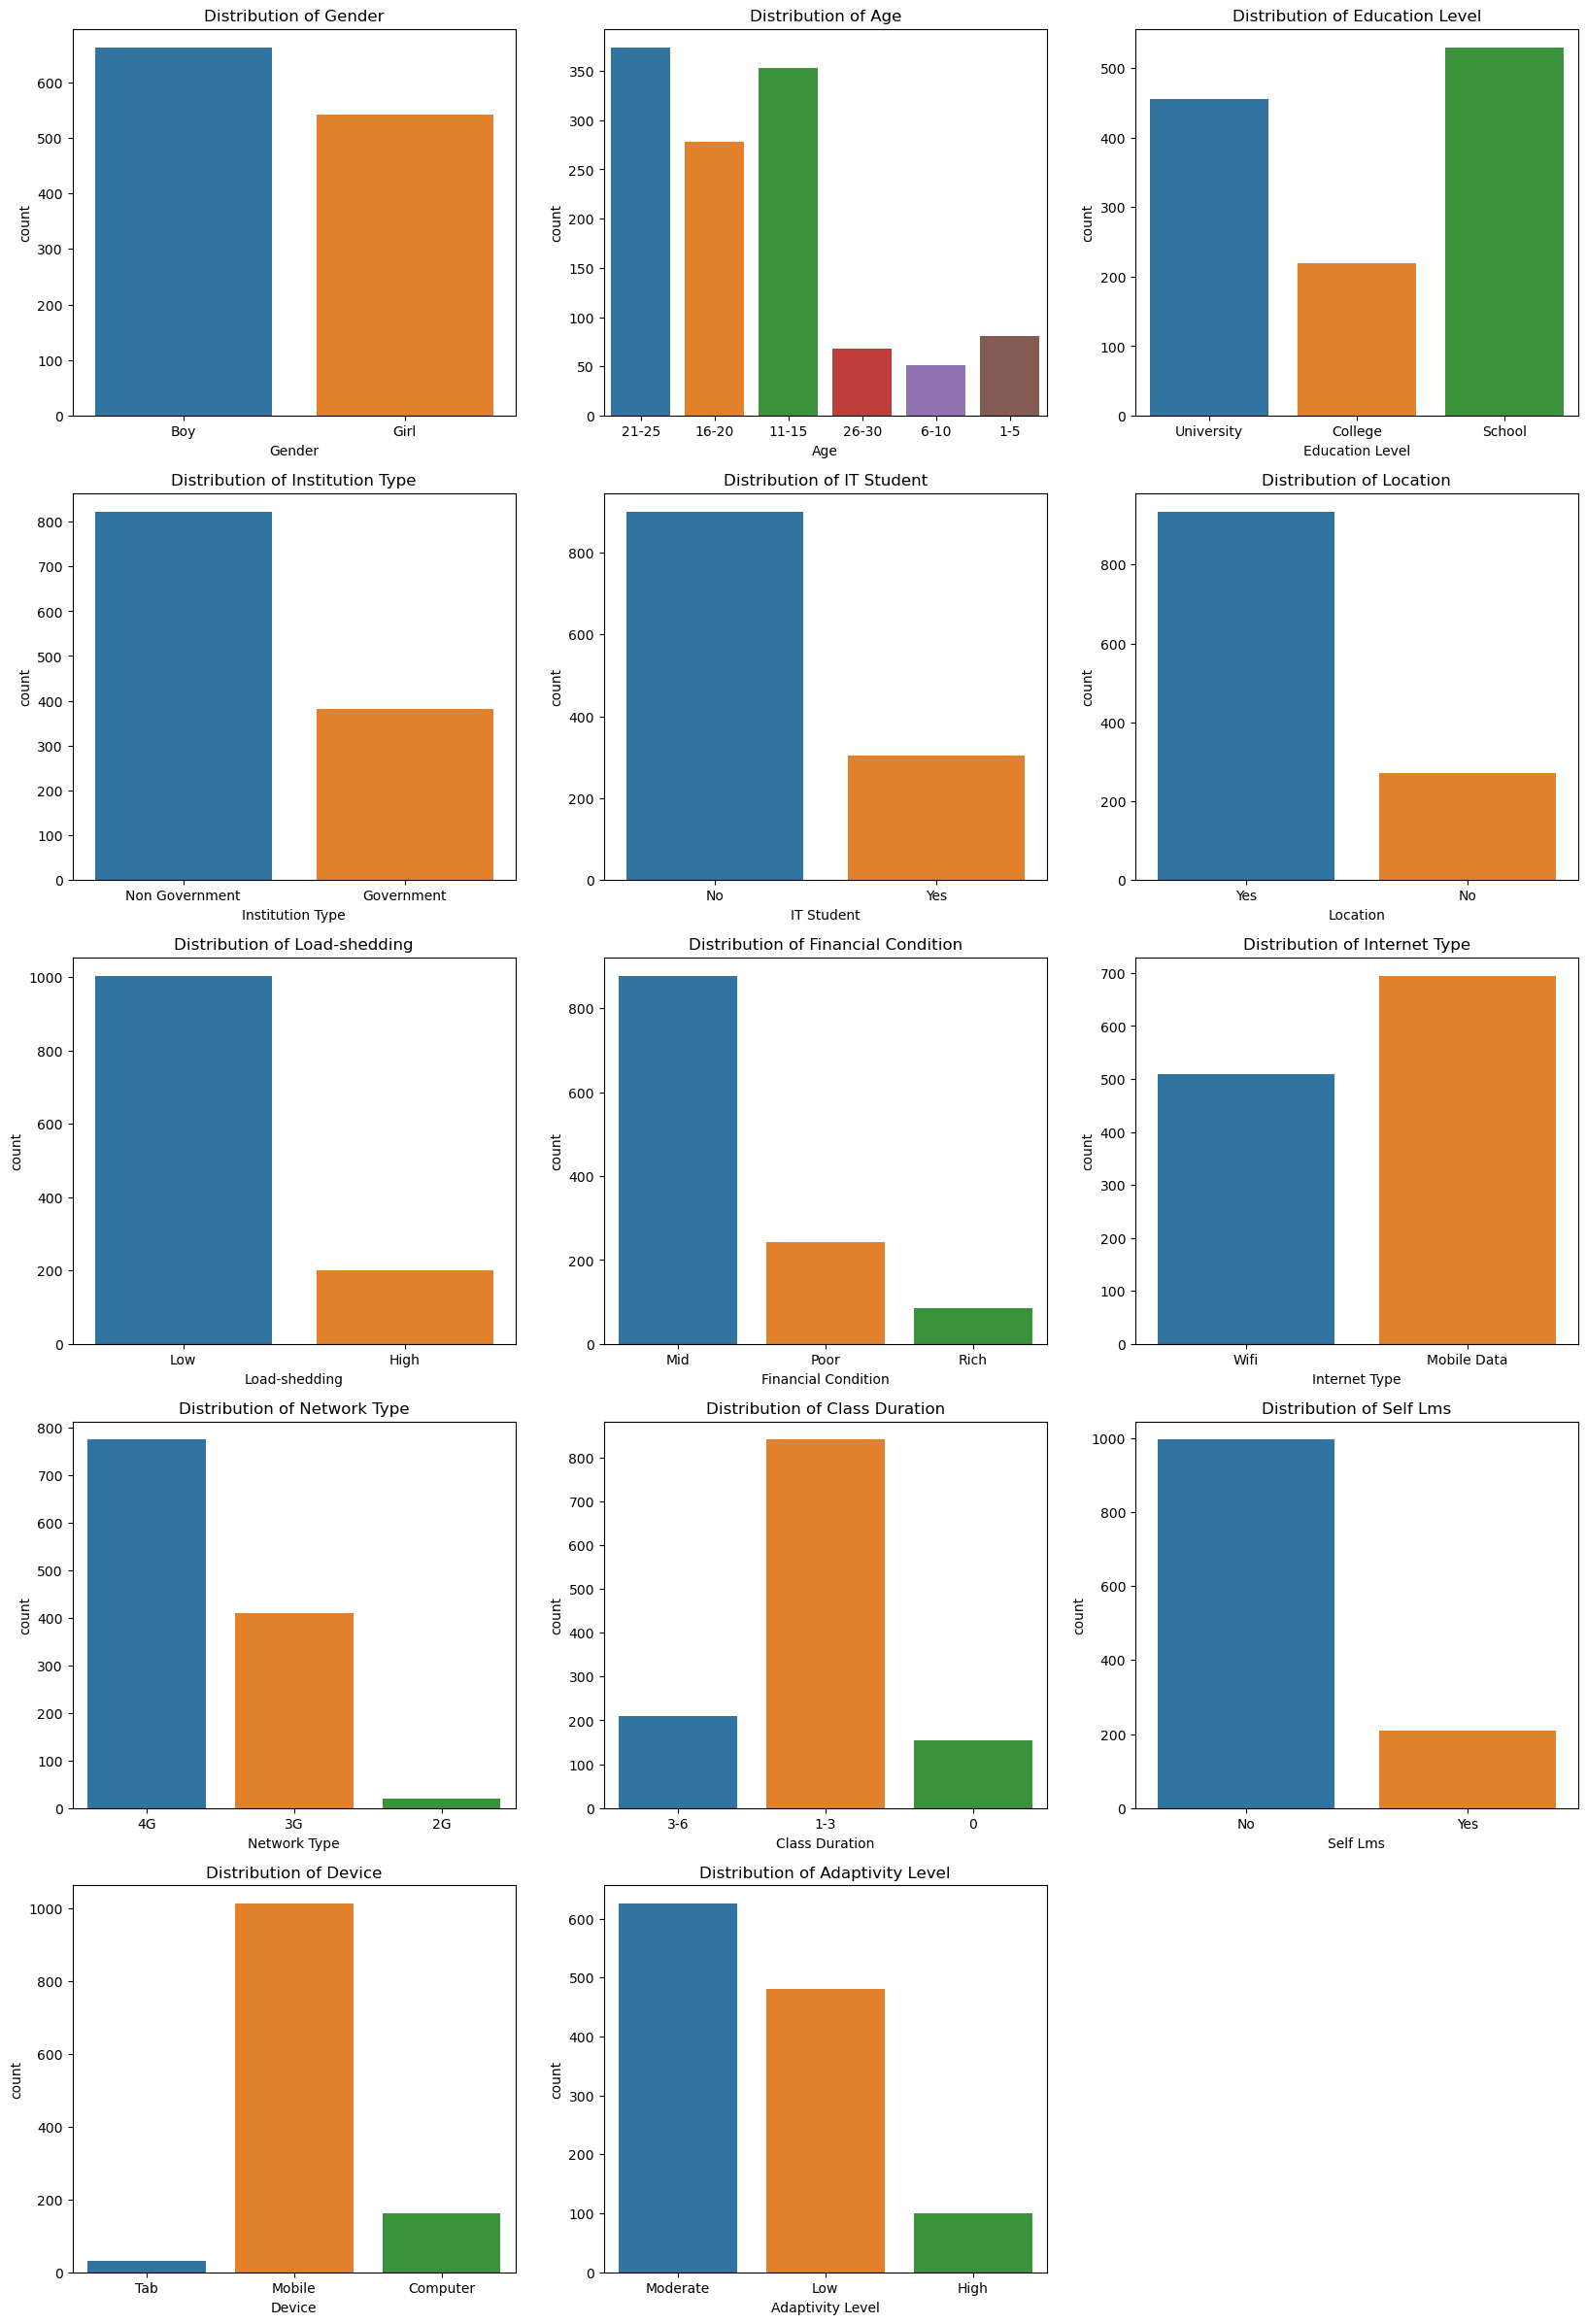

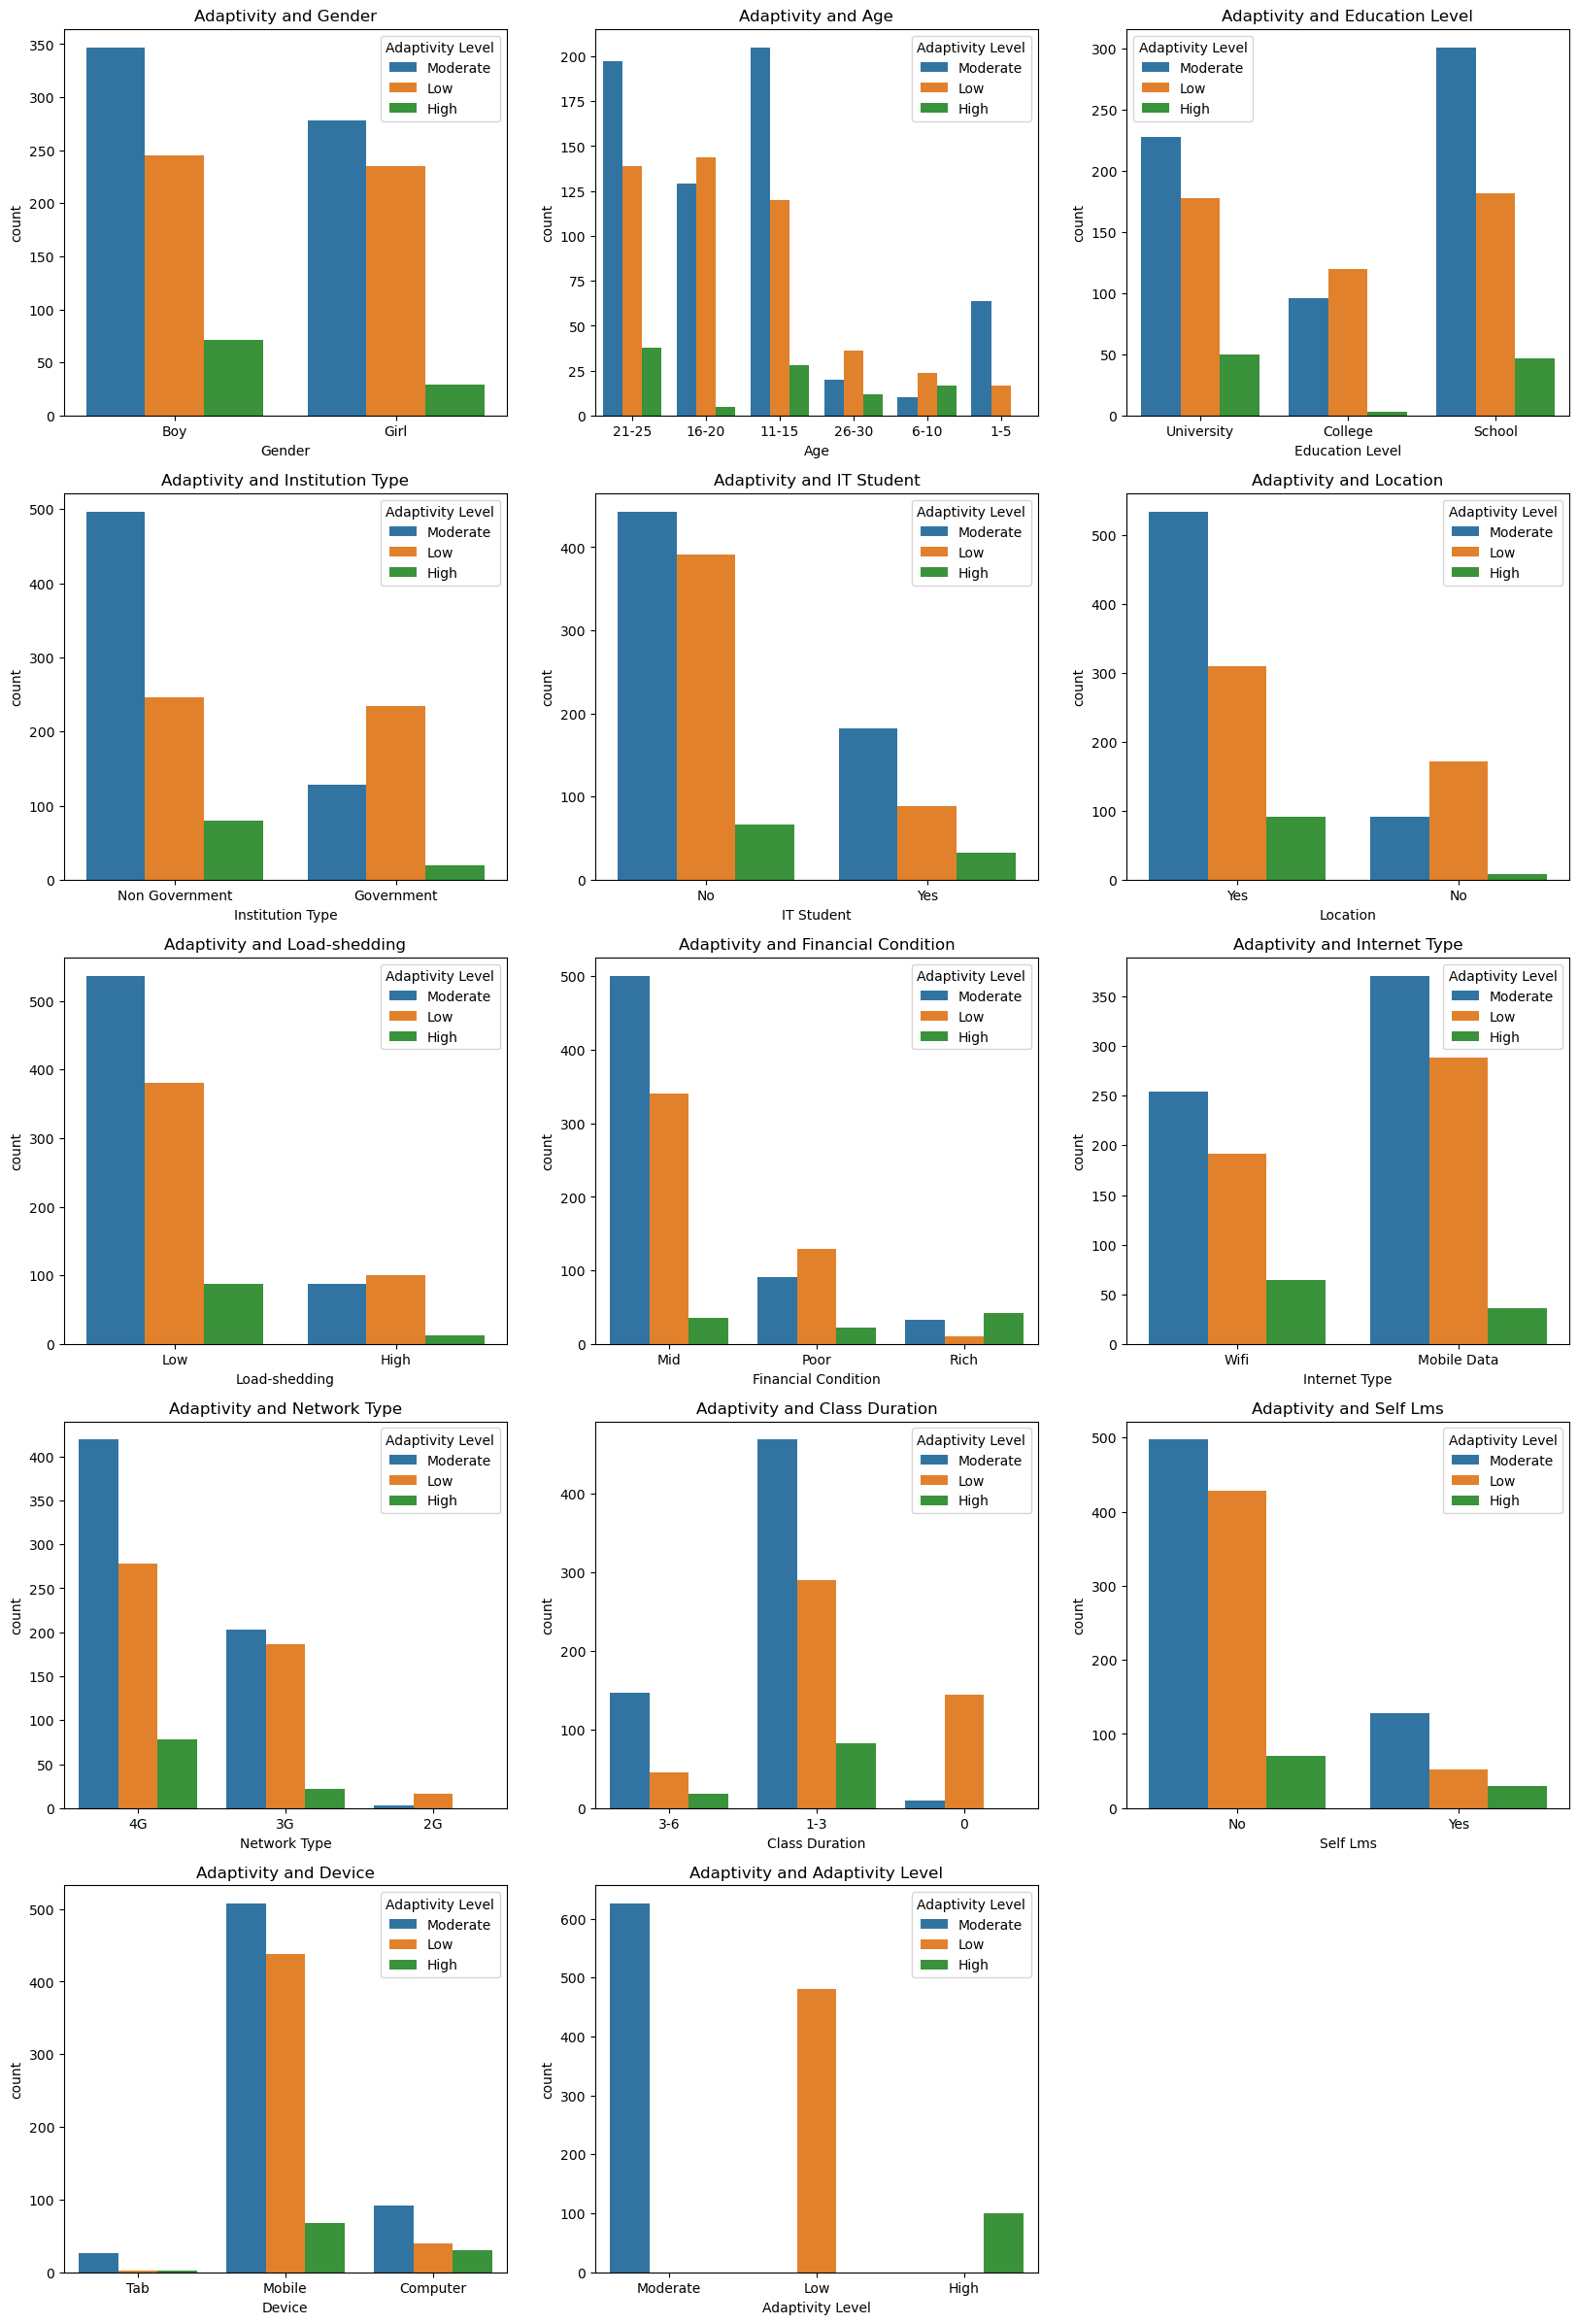

In [4]:
# Examining the distribution of features
def plot(df, width, height, column=None):
    plt.figure(figsize=(width, height))
    row_count = math.ceil(df.shape[1] / 3)
    for (index, col) in enumerate(df):
        plt.subplot(int(row_count), 3, index + 1)
        if column == None:
            sns.countplot(x=col, data=df).set(title=f'Distribution of {col}')
        else: 
            sns.countplot(x=col, hue=column, data=df).set(title=f'Adaptivity and {col}')

plot(df, 20, 30)
plot(df, 20, 30, 'Adaptivity Level')

In [5]:
df = df.drop(df[df['Network Type']=='2G'].index)
df

,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity Level
0,Boy,21-25,University,Non Government,No,Yes,Low,Mid,Wifi,4G,3-6,No,Tab,Moderate
1,Girl,21-25,University,Non Government,No,Yes,High,Mid,Mobile Data,4G,1-3,Yes,Mobile,Moderate
2,Girl,16-20,College,Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,Moderate
3,Girl,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,4G,1-3,No,Mobile,Moderate
4,Girl,16-20,School,Non Government,No,Yes,Low,Poor,Mobile Data,3G,0,No,Mobile,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,Girl,16-20,College,Non Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,Low
1201,Girl,16-20,College,Non Government,No,No,High,Mid,Wifi,4G,3-6,No,Mobile,Moderate
1202,Boy,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,3G,1-3,No,Mobile,Moderate
1203,Girl,16-20,College,Non Government,No,No,Low,Mid,Wifi,4G,1-3,No,Mobile,Low


In [6]:
## Preprocessing the categorical data 
preprocesser = Utils()
df = preprocesser.labeling(df)
preprocesser.mapping

[{'Gender': {'Boy': 0, 'Girl': 1}},
 {'Age': {'21-25': 0,
   '16-20': 1,
   '11-15': 2,
   '26-30': 3,
   '6-10': 4,
   '1-5': 5}},
 {'Education Level': {'University': 0, 'College': 1, 'School': 2}},
 {'Institution Type': {'Non Government': 0, 'Government': 1}},
 {'IT Student': {'No': 0, 'Yes': 1}},
 {'Location': {'Yes': 0, 'No': 1}},
 {'Load-shedding': {'Low': 0, 'High': 1}},
 {'Financial Condition': {'Mid': 0, 'Poor': 1, 'Rich': 2}},
 {'Internet Type': {'Wifi': 0, 'Mobile Data': 1}},
 {'Network Type': {'4G': 0, '3G': 1}},
 {'Class Duration': {'3-6': 0, '1-3': 1, '0': 2}},
 {'Self Lms': {'No': 0, 'Yes': 1}},
 {'Device': {'Tab': 0, 'Mobile': 1, 'Computer': 2}},
 {'Adaptivity Level': {'Moderate': 0, 'Low': 1, 'High': 2}}]

In [8]:
# 1. Chi2-Test
from scipy.stats import chi2_contingency

def chi2_test(df):
    not_significant = []
    for index, val in enumerate(df):
        contigency = pd.crosstab(index = df[val], columns=df['Adaptivity Level'])
        result = chi2_contingency(contigency)  # stat, p, dof, expected
        if result[1] > 0.05:
            not_significant.append(val)
    return not_significant

result = chi2_test(df)
if len(result) == 0:
    print('All values are significant')

All values are significant


In [9]:
## Handling imbalances in data
smote = Smote(df, 100, 5)
generated_data = smote.smote()
generated_data = np.append(generated_data, np.ones((generated_data.shape[0],1)) * 2, axis=1)
df = df.append(pd.DataFrame(generated_data, columns=df.columns.tolist()))
df.shape


/var/folders/xn/ckzmp8n52bj64l343d38bl4r0000gn/T/ipykernel_36091/2734634180.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(generated_data, columns=df.columns.tolist()))


(1286, 14)

In [10]:
X = df.iloc[:, :-1].values
Y = df.iloc[:, -1:].values

In [11]:
## Applying one hot encoding to response
one_hot_df = preprocesser.one_hot_encoding(df, 'Adaptivity Level')
one_hot_df.rename(columns={'Adaptivity Level_0.0': 'Adaptivity Level_Moderate', 
                           'Adaptivity Level_1.0': 'Adaptivity Level_Low', 
                           'Adaptivity Level_2.0': 'Adaptivity Level_High',}, inplace=True)

In [12]:
df.reset_index(drop=True, inplace=True)

In [13]:
one_hot_df.reset_index(drop=True, inplace=True)
one_hot_df = one_hot_df.reindex(columns=one_hot_df.columns.tolist()[:13] + ['Adaptivity Level_High', 'Adaptivity Level_Low', 'Adaptivity Level_Moderate'])
one_hot_df.head()

,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity Level_High,Adaptivity Level_Low,Adaptivity Level_Moderate
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0,0,1
2,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,0,1
3,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,1
4,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,0,1,0


In [14]:
# Logistic Regression
logistic_regression = LogisticRegression(0.03, 10000)
weight = np.zeros((13,1))
print(logistic_regression.k_fold_cross(one_hot_df, weight, 10))

0.334375


In [11]:
logistic_regression = LogisticRegression(0.03, 10000, True, 2, 0.1)
print(logistic_regression.k_fold_cross(one_hot_df, weight, 10))

0.3307692307692307


In [12]:
logistic_regression = LogisticRegression(0.03, 10000, True, 1, 0.1)
print(logistic_regression.k_fold_cross(one_hot_df, weight, 10))

0.3292307692307692


In [11]:
# applying pca
pca = PCA(X)

In [12]:
pca.pve(8)

0.8683698639797499

In [13]:
pca_x = pca.examine(8)

new_features = X @ pca_x

In [14]:
new_features = pd.DataFrame(new_features, columns=["PC"+str(i) for i in range(1,9)])
pca_df = pd.concat([new_features, one_hot_df.iloc[:, -3:]], axis=1)
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,Adaptivity Level_High,Adaptivity Level_Low,Adaptivity Level_Moderate
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1
1,0.014271,-0.288598,0.539143,0.541393,-0.611231,-0.312116,-1.172591,0.623992,0,0,1
2,1.391734,-0.360818,0.607994,0.275675,0.422856,-0.334131,-1.261765,-0.352417,0,0,1
3,2.796678,-0.734908,-0.002132,0.300622,-0.204540,-0.018798,-1.212952,0.450636,0,0,1
4,2.107687,-1.011852,-0.322316,1.761878,-0.096840,-0.167237,-2.085460,0.485056,0,1,0


In [15]:
logistic_regression = LogisticRegression(0.03, 10000, True, 1, 0.1)
weight = np.zeros((8,1))
print(logistic_regression.k_fold_cross(pca_df, weight, 10))

0.37461538461538463


In [14]:
## Naive Bayes
nb = NaiveBayes()
print(k_fold_cross(nb,df, 10))

0.3936


In [15]:
pca_df = pd.concat([new_features, df.iloc[:, -1:]], axis=1)
print(k_fold_cross(nb, pca_df, 10))

NameError: name 'new_features' is not defined

In [18]:
df.head()

,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity Level
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
2,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0


In [7]:
# KNN Classifier
knn = KNN(10)
print(k_fold_cross(knn, df, 5))

0.47932489451476795


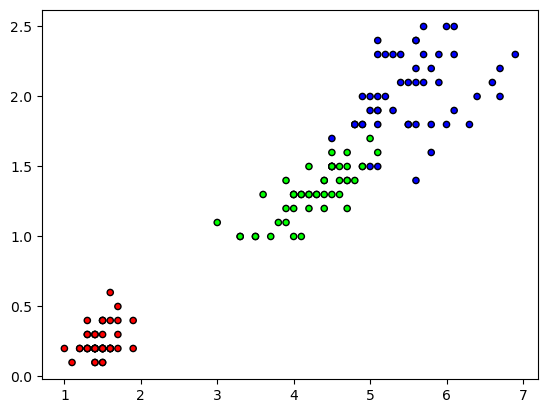

[1 1 2 0 1 0 0 0 1 2 1 0 2 1 0 1 2 0 2 1 1 1 2 1 2 0 2 1 2 0]
0.9666666666666667


In [7]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from KNN import KNN

cmap = ListedColormap(['#FF0000','#00FF00','#0000FF'])

iris = datasets.load_iris()
X, y = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

plt.figure()
plt.scatter(X[:,2],X[:,3], c=y, cmap=cmap, edgecolor='k', s=20)
plt.show()


clf = KNN(5)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

print(predictions)

acc = np.sum(predictions == y_test) / len(y_test)
print(acc)

In [10]:
clf = KNN(10)
X_test = [X[index] for index in range(0, X.shape[0], 10)]
y_test = [Y[index] for index in range(0, Y.shape[0], 10)]
Xtrain = [X[index] for index in range(X.shape[0]) if index % 10 != 0]
Ytrain = [Y[index] for index in range(Y.shape[0]) if index % 10 != 0]
clf.fit(Xtrain, Ytrain)
predictions = clf.predict(X_test)

print(predictions)

acc = np.sum(predictions == y_test) / len(y_test)
print(acc)

[0 1 1 1 1 1 0 0 1 0 0 1 0 1 0 0 1 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0 1 0 1 1 1 1
 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1]
61.25954198473283


In [25]:
for col in df.columns:
    if 'Age' in col:
        df[col+'_Girl'] = df[col]*df['Gender']

In [27]:
df = df.reindex(columns=df.columns.tolist()[:-2] + ['Age_Girl', 'Adaptivity Level'])

In [28]:
df

,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Age_Girl,Adaptivity Level
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
2,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,0.0
4,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,0.0,3.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0
1301,0.0,3.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,2.0,0.0,2.0
1302,0.0,3.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,2.0,0.0,2.0
1303,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0


In [11]:
# KNN Classifier
knn = KNN(10)
print(k_fold_cross(knn, df, 5))

0.496551724137931


In [30]:
# Logistic Regression
logistic_regression = LogisticRegression(0.03, 10000)
weight = np.zeros((13,1))
print(logistic_regression.k_fold_cross(one_hot_df, weight, 10))

0.3230769230769231
